In [6]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import optuna

In [7]:
print(torch.cuda.is_available())
print(torch.version.cuda)

False
None


In [8]:
df_train = pd.read_csv("train.csv", index_col = "id")
df_test=pd.read_csv("test.csv",index_col="id")
df_train.sample(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
18082,Audi,A3 2.0T Premium,2016,87500,Gasoline,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Gray,Black,None reported,Yes,16000
115298,Genesis,G80 3.3T Sport,2023,2500,Gasoline,365.0HP 3.3L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Gray,Black,None reported,Yes,44999
173330,Nissan,Versa 1.8 S,2010,151544,Gasoline,122.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,A/T,Black,–,None reported,Yes,10000
188407,Cadillac,Escalade Premium Luxury Platinum,2022,6200,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,Black,None reported,Yes,61995
143099,Hyundai,Sonata Hybrid Limited,2015,79000,Hybrid,199.0HP 2.4L 4 Cylinder Engine Gas/Electric Hy...,A/T,Black,Gray,At least 1 accident or damage reported,Yes,17000
2896,Kia,Sorento SXL,2019,43875,Gasoline,3.3L V6 24V GDI DOHC,8-Speed Automatic,Glacial White Pearl,Black,At least 1 accident or damage reported,NaN,25925
178621,Chevrolet,Silverado 1500 LT,2013,83112,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Black,Black,At least 1 accident or damage reported,Yes,20000
176539,Ford,Focus SE,2015,60109,E85 Flex Fuel,160.0HP 2.0L 4 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,Black,Black,None reported,Yes,11995
72307,Mercedes-Benz,Sprinter High Roof,2016,2500,Gasoline,188.0HP 3.0L V6 Cylinder Engine Diesel Fuel,7-Speed A/T,Black,Black,None reported,Yes,41999


In [9]:
df_train.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [10]:
df_train["fuel_type"] = df_train["fuel_type"].replace('–', np.nan)
df_test["fuel_type"] = df_test["fuel_type"].replace('–', np.nan)
df_train["transmission"]=df_train["transmission"].replace('–', np.nan)
df_test["transmission"]=df_test["transmission"].replace('–', np.nan)
df_train["int_col"]=df_train["int_col"].replace('–', np.nan)
df_test["int_col"]=df_test["int_col"].replace('–', np.nan)
df_train["ext_col"]=df_train["ext_col"].replace('–', np.nan)
df_test["ext_col"]=df_test["ext_col"].replace('–', np.nan)
df_train["fuel_type"].unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', 'not supported'], dtype=object)

In [11]:
# Pattern to extract horsepower
hp_pattern = r'(\d+\.?\d*)HP'

# Pattern to extract engine size
size_pattern = r'(\d+\.?\d*)(L| Liter| L)'

# Pattern to extract number of cylinders
cylinders_pattern = r'(\d+) (Cylinder)'

# Pattern to extract fuel type
fuelpattern = r'(Gasoline|Diesel|Electric/Gas|Electric|Gas/Electric)'

In [12]:
def extract_horsepower(engine_str):
    match = re.search(hp_pattern, engine_str)
    return float(match.group(1)) if match else None

def extract_engine_size(engine_str):
    match = re.search(size_pattern, engine_str)
    return float(match.group(1)) if match else None

def extract_cylinders(engine_str):
    match = re.search(cylinders_pattern, engine_str)
    return int(match.group(1)) if match else None

def extract_fuel_type(engine_str):
    match = re.search(fuelpattern, engine_str)
    return match.group(1) if match else None

In [13]:
df_train['horsepower'] = df_train['engine'].apply(extract_horsepower)
df_train['engine_size'] = df_train['engine'].apply(extract_engine_size)
df_train['cylinders'] = df_train['engine'].apply(extract_cylinders)
df_train['fueltype'] = df_train['engine'].apply(extract_fuel_type)
df_test['horsepower'] = df_test['engine'].apply(extract_horsepower)
df_test['engine_size'] = df_test['engine'].apply(extract_engine_size)
df_test['cylinders'] = df_test['engine'].apply(extract_cylinders)
df_test['fueltype'] = df_test['engine'].apply(extract_fuel_type)


In [14]:
df_train["fuel_type"] = df_train["fuel_type"].fillna(df_train["fueltype"])
df_test["fuel_type"] = df_test["fuel_type"].fillna(df_test["fueltype"])

In [15]:
df_train["fuel_type"].value_counts()

fuel_type
Gasoline          165993
Hybrid              6832
E85 Flex Fuel       5406
Electric            4854
Diesel              3957
Plug-In Hybrid       521
not supported         15
Gas/Electric           3
Name: count, dtype: int64

In [16]:
df_train.drop(columns=["engine","fueltype"], axis=1,inplace=True)
df_test.drop(columns=["engine","fueltype"], axis=1,inplace=True)

In [17]:
df_train["fuel_type"] = df_train["fuel_type"].fillna("Unknown")
df_train["int_col"] = df_train["int_col"].fillna("Unknown")
df_train["ext_col"] = df_train["ext_col"].fillna("Unknown")

# Fill 'accident' missing values with 'None reported'
df_train["accident"] = df_train["accident"].fillna("None reported")

# Fill 'clean_title' missing values with 'Unknown'
df_train["clean_title"] = df_train["clean_title"].fillna("Unknown")

# Fill numerical columns using interpolation
df_train["horsepower"] = df_train["horsepower"].interpolate(method='linear')
df_train["engine_size"] = df_train["engine_size"].interpolate(method='linear')
df_train["cylinders"] = df_train["cylinders"].interpolate(method='linear')
df_train["transmission"] = df_train["transmission"].fillna("Unknown")

df_test["fuel_type"] = df_test["fuel_type"].fillna("Unknown")
df_test["int_col"] = df_test["int_col"].fillna("Unknown")
df_test["ext_col"] = df_test["ext_col"].fillna("Unknown")
df_test["accident"] = df_test["accident"].fillna("None reported")
df_test["clean_title"] = df_test["clean_title"].fillna("Unknown")

df_test["horsepower"] = df_test["horsepower"].interpolate(method='linear')
df_test["engine_size"] = df_test["engine_size"].interpolate(method='linear')
df_test["cylinders"] = df_test["cylinders"].interpolate(method='linear')
df_test["transmission"] = df_test["transmission"].fillna("Unknown")



In [44]:
print(df_test.isnull().sum())
print(df_train.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
horsepower      0
engine_size     0
cylinders       0
dtype: int64
brand           0
model           0
model_year      0
milage          0
fuel_type       0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
horsepower      0
engine_size     0
cylinders       0
dtype: int64


In [19]:
for col in df_train.columns:
    print(col , df_train[col].nunique())



brand 57
model 1897
model_year 34
milage 6651
fuel_type 9
transmission 52
ext_col 319
int_col 156
accident 2
clean_title 2
price 1569
horsepower 2805
engine_size 258
cylinders 79


In [20]:
cat_cols=df_train.select_dtypes(include="object")
num_cols=df_train.select_dtypes(exclude="object")

/var/folders/dp/w9766y9x00j7vmxb8b37p1bc0000gp/T/ipykernel_1326/1814270078.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[col])
/var/folders/dp/w9766y9x00j7vmxb8b37p1bc0000gp/T/ipykernel_1326/1814270078.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[col])
/var/folders

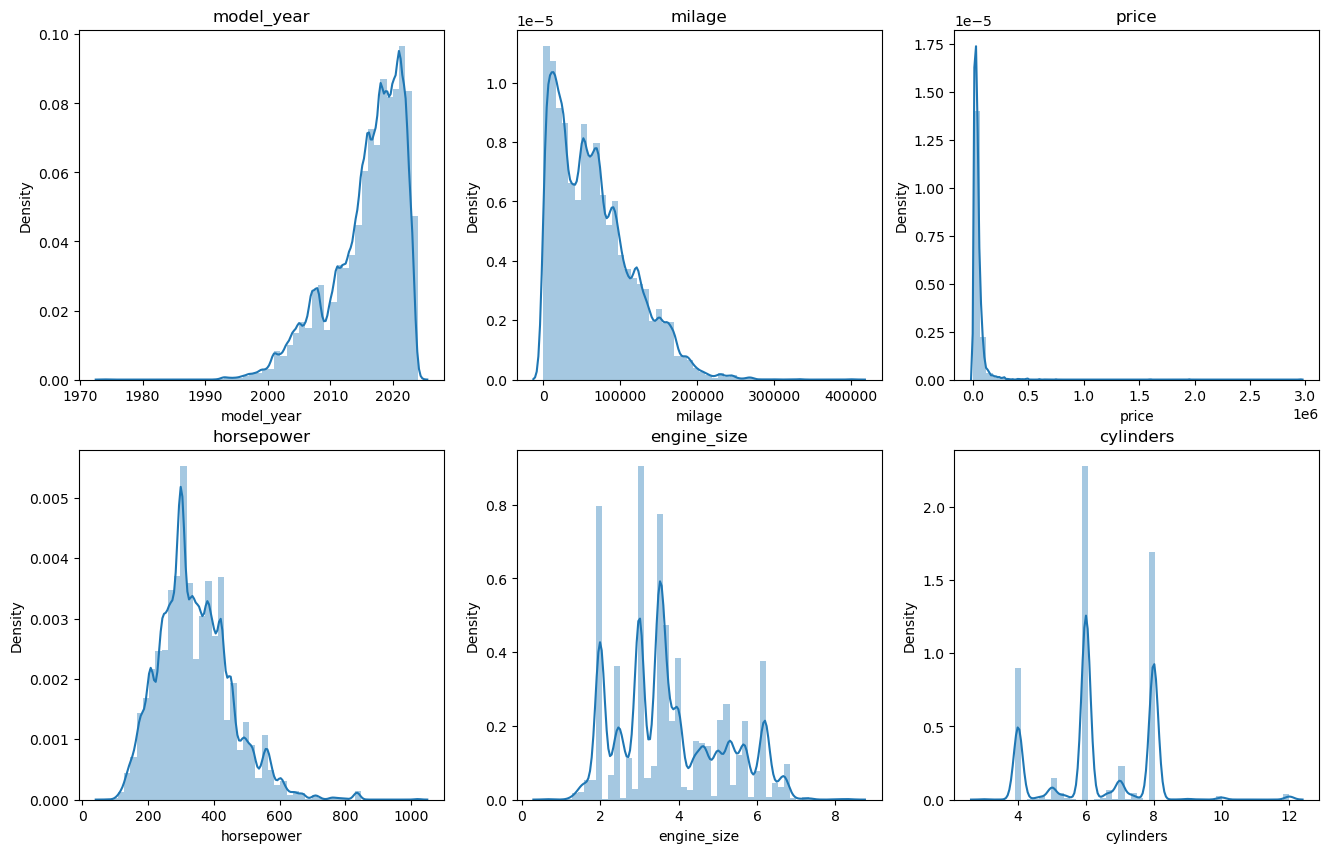

In [21]:
plt.figure(figsize=(16,10))
for i,col in enumerate(num_cols,1):
    plt.subplot(2,3,i)
    sns.distplot(df_train[col])
    plt.title(col);

In [22]:
df_train.describe()

,model_year,milage,price,horsepower,engine_size,cylinders
count,188533.000000,188533.000000,1.885330e+05,188533.00000,188533.000000,188533.000000
mean,2015.829998,65705.295174,4.387802e+04,343.11729,3.774957,6.371945
std,5.660967,49798.158076,7.881952e+04,109.73811,1.340617,1.477156
min,1974.000000,100.000000,2.000000e+03,70.00000,0.650000,3.000000
25%,2013.000000,24115.000000,1.700000e+04,268.00000,3.000000,6.000000
50%,2017.000000,57785.000000,3.082500e+04,332.00000,3.500000,6.000000
75%,2020.000000,95400.000000,4.990000e+04,411.00000,4.700000,8.000000
max,2024.000000,405000.000000,2.954083e+06,1020.00000,8.400000,12.000000


In [23]:
for col in num_cols:
    print(f'{col}: {df_train[col].skew().round(2)}')

model_year: -1.04
milage: 0.9
price: 20.27
horsepower: 0.78
engine_size: 0.48
cylinders: 0.15


In [24]:
for col in num_cols:
    print(f'{col}: {df_train[col].kurt().round(2)}')

model_year: 0.75
milage: 0.68
price: 623.97
horsepower: 1.37
engine_size: -0.62
cylinders: 0.21


In [25]:
X=df_train.drop(columns="price")
y=df_train["price"]

In [26]:
X.to_csv("features.csv")

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [28]:
num_cols=X.select_dtypes(exclude="object").columns.values

scaler=StandardScaler()
X_train[num_cols]=scaler.fit_transform(X_train[num_cols])
X_test[num_cols]=scaler.transform(X_test[num_cols])
df_test[num_cols]=scaler.transform(df_test[num_cols])

In [29]:
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file) 

In [30]:
X_train

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,horsepower,engine_size,cylinders
id,,,,,,,,,,,,,
103371,Chevrolet,2500 Tradesman,0.382971,-0.094049,Gasoline,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,0.609639,1.959135,1.102496
91507,Chevrolet,Suburban Premier,0.206589,0.802892,Gasoline,6-Speed A/T,Black,Black,None reported,Yes,0.108291,1.137884,1.102496
136888,Subaru,BRZ Limited,1.088503,-0.234613,Gasoline,6-Speed M/T,Gray,Black,At least 1 accident or damage reported,Yes,-1.049368,-1.027234,-1.609777
163757,Saab,9-3 Aero,0.735737,-0.927394,Gasoline,9-Speed A/T,Black,Black,None reported,Yes,-0.575366,-1.325871,-1.609777
10742,Lexus,GX 460 Base,-0.675326,0.438088,Gasoline,6-Speed A/T,Black,Black,None reported,Yes,-0.383942,0.615269,1.102496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59377,Chevrolet,Tahoe Premier,0.735737,-0.158307,Gasoline,A/T,Gray,Black,None reported,Yes,0.108291,1.137884,1.102496
79805,Chevrolet,Corvette Stingray w/1LT,1.264886,-1.258725,Gasoline,8-Speed A/T,Red,Brown,None reported,Yes,1.338873,1.809817,1.102496
145111,BMW,640 i,-1.028092,0.046315,Gasoline,6-Speed M/T,Gray,Black,None reported,Yes,-0.256326,-0.579279,-0.253641


In [31]:
for col in cat_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")
    df_test[col] = df_test[col].astype("category")


In [32]:
# def objective(trial):
#     # Define hyperparameter search space
#     params = {
#         "iterations": trial.suggest_int("iterations", 500, 2000),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "depth": trial.suggest_int("depth", 4, 10),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         "border_count": trial.suggest_int("border_count", 32, 255),
#         "random_strength": trial.suggest_float("random_strength", 1e-9, 10, log=True),
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "task_type": "GPU" if torch.cuda.is_available() else "CPU"  # Use GPU if available
#     }

#     # Define model
#     model = CatBoostRegressor(**params, cat_features=cat_cols.columns.values, verbose=0)

#     # Perform cross-validation
#     score = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_squared_error").mean()

#     return score  # Optuna maximizes by default, but we are minimizing MSE (negative for that)


In [33]:
# study = optuna.create_study(direction="maximize")  # Since we're using negative MSE
# study.optimize(objective, n_trials=50, n_jobs=-1)  # Run 50 trials

# # Print the best parameters
# print("Best hyperparameters:", study.best_params_)


In [34]:
best_params ={
    'iterations': 740, 'learning_rate': 0.025662985213769834, 'depth': 8, 'l2_leaf_reg': 1.7842544149607396,
      'bagging_temperature': 0.3447398708716999, 'border_count': 243, 
      'random_strength': 0.03131242633217159, 'boosting_type': 'Plain'}

In [35]:
model=CatBoostRegressor(cat_features=cat_cols.columns.values,**best_params, loss_function= 'RMSE')

In [36]:
model.fit(X_train,y_train)

0:	learn: 77839.3093752	total: 177ms	remaining: 2m 11s
1:	learn: 77592.0302328	total: 273ms	remaining: 1m 40s
2:	learn: 77363.1292618	total: 405ms	remaining: 1m 39s
3:	learn: 77136.4223475	total: 545ms	remaining: 1m 40s
4:	learn: 76920.6356421	total: 666ms	remaining: 1m 37s
5:	learn: 76715.8560853	total: 746ms	remaining: 1m 31s
6:	learn: 76517.7575172	total: 832ms	remaining: 1m 27s
7:	learn: 76338.6908299	total: 927ms	remaining: 1m 24s
8:	learn: 76163.0973565	total: 1.03s	remaining: 1m 23s
9:	learn: 75991.2384016	total: 1.12s	remaining: 1m 22s
10:	learn: 75834.3644328	total: 1.22s	remaining: 1m 21s
11:	learn: 75675.1262650	total: 1.32s	remaining: 1m 20s
12:	learn: 75530.9481140	total: 1.41s	remaining: 1m 18s
13:	learn: 75384.6926954	total: 1.5s	remaining: 1m 17s
14:	learn: 75248.5045738	total: 1.6s	remaining: 1m 17s
15:	learn: 75110.4012774	total: 1.68s	remaining: 1m 15s
16:	learn: 74985.8193240	total: 1.79s	remaining: 1m 16s
17:	learn: 74862.8734948	total: 1.9s	remaining: 1m 16s
18:	l

In [37]:
y_pred=model.predict(X_test)

In [38]:
RMSE=np.sqrt(mean_squared_error(y_test,y_pred))
R2= r2_score(y_test,y_pred)

In [39]:
print(f'RMSE:{RMSE},R2_SCORE:{R2}')

RMSE:76095.21067511885,R2_SCORE:0.13115255517006852


In [40]:
with open("cat_model.pkl", "wb") as file:
    pickle.dump(model,file)

In [41]:
y_df = model.predict(df_test)

In [42]:
y_df

array([17154.92505372, 80275.53927835, 60063.9906114 , ...,
       22818.86160791, 17211.66999483, 35924.68926312])

In [43]:
submission =pd.read_csv("sample_submission.csv",index_col="id")
submission["price"]=y_df.round(3)
submission.to_csv("cat_submission.csv")